In [16]:
from multiprocessing import Pool
from sklearn.utils import class_weight
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmnb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder ,StandardScaler,LabelEncoder
import torch

!pip install pandarallel
from pandarallel import pandarallel as pl
pl.initialize(progress_bar=True, verbose=0)

pd.set_option('mode.chained_assignment', None)

In [17]:
pffScoutingData_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/pffScoutingData.csv')
pffScoutingData_df

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188249,2021110100,4433,52507,Pass Block,LT,NaN,NaN,NaN,0.0,0.0,1.0,0.0,43338.0,PP,0.0
188250,2021110100,4433,52546,Coverage,SCBoR,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188251,2021110100,4433,52573,Pass Route,SLoWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188252,2021110100,4433,52585,Pass Rush,LEO,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
players_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2023/players.csv')
players_df

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick
...,...,...,...,...,...,...,...
1674,53991,6-1,320,NaN,NaN,DT,Forrest Merrill
1675,53994,6-5,300,NaN,NaN,C,Ryan McCollum
1676,53999,6-4,312,NaN,NaN,DT,Jack Heflin
1677,54006,6-6,330,NaN,NaN,T,Jake Curhan


# **pffScoutingData_df和players_df做left join**

In [19]:
pffScoutingJoinPlayers = pd.merge(pffScoutingData_df, players_df, how='left', on='nflId')
pffScoutingJoinPlayers

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,...,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,height,weight,birthDate,collegeName,officialPosition,displayName
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6-6,265,1989-05-14,Arizona,TE,Rob Gronkowski
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5-10,185,07/10/1988,Central Michigan,WR,Antonio Brown
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5-9,205,1991-11-22,North Carolina,RB,Giovani Bernard
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,...,0.0,44955.0,SW,0.0,6-4,319,1991-05-27,Colorado State-Pueblo,C,Ryan Jensen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188249,2021110100,4433,52507,Pass Block,LT,NaN,NaN,NaN,0.0,0.0,...,0.0,43338.0,PP,0.0,6-7,303,1997-06-11,Connecticut,T,Matt Peart
188250,2021110100,4433,52546,Coverage,SCBoR,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,6-1,193,1997-01-21,Louisiana Tech,CB,L'Jarius Sneed
188251,2021110100,4433,52573,Pass Route,SLoWR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6-6,215,1997-09-23,Texas,WR,Collin Johnson
188252,2021110100,4433,52585,Pass Rush,LEO,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,6-2,255,NaN,Michigan,DE,Michael Danna


# **取OLB位置的球員**

In [20]:
officialPositionFilter = pffScoutingJoinPlayers['officialPosition'] == 'OLB'
pffScoutingJoinPlayers = pffScoutingJoinPlayers.loc[officialPositionFilter]

pffScoutingJoinPlayers.drop(['pff_beatenByDefender', 
                             'pff_hitAllowed', 
                             'pff_hurryAllowed', 
                             'pff_sackAllowed', 
                             'pff_nflIdBlockedPlayer', 
                             'pff_blockType', 
                             'pff_backFieldBlock', 
                             'collegeName', 
                             'displayName'], axis = 1, inplace = True)

pffScoutingJoinPlayers['birthDate']=pffScoutingJoinPlayers['birthDate'].fillna(0)

pffScoutingJoinPlayers

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,height,weight,birthDate,officialPosition
20,2021090900,97,53441,Pass Rush,LILB,0.0,1.0,0.0,6-3,245,0,OLB
27,2021090900,137,41915,Coverage,SCBoL,0.0,0.0,0.0,6-2,250,1992-11-17,OLB
43,2021090900,137,53461,Pass Rush,SCBR,0.0,0.0,0.0,6-5,262,0,OLB
48,2021090900,187,41915,Coverage,SCBiL,0.0,0.0,0.0,6-2,250,1992-11-17,OLB
71,2021090900,282,41915,Pass Rush,LOLB,0.0,0.0,0.0,6-2,250,1992-11-17,OLB
...,...,...,...,...,...,...,...,...,...,...,...,...
188138,2021110100,4113,52591,Pass Rush,LOLB,0.0,0.0,0.0,6-5,233,1998-04-01,OLB
188140,2021110100,4113,53479,Pass Rush,REO,0.0,0.0,0.0,6-2,250,0,OLB
188142,2021110100,4113,53645,Pass Rush,LEO,0.0,0.0,0.0,6-3,232,0,OLB
188162,2021110100,4310,53479,Pass Rush,REO,0.0,0.0,0.0,6-2,250,0,OLB


# **計算年齡**

In [21]:
def setAgeCol(df): 
    for index, row in df.iterrows():
        if row['birthDate'] == 0:
            df.loc[index, 'age'] = 0
        else: 
            df.loc[index, 'age'] = 2022 - (int) (row['birthDate'].split('-')[0])
    
setAgeCol(pffScoutingJoinPlayers)
pffScoutingJoinPlayers

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,height,weight,birthDate,officialPosition,age
20,2021090900,97,53441,Pass Rush,LILB,0.0,1.0,0.0,6-3,245,0,OLB,0.0
27,2021090900,137,41915,Coverage,SCBoL,0.0,0.0,0.0,6-2,250,1992-11-17,OLB,30.0
43,2021090900,137,53461,Pass Rush,SCBR,0.0,0.0,0.0,6-5,262,0,OLB,0.0
48,2021090900,187,41915,Coverage,SCBiL,0.0,0.0,0.0,6-2,250,1992-11-17,OLB,30.0
71,2021090900,282,41915,Pass Rush,LOLB,0.0,0.0,0.0,6-2,250,1992-11-17,OLB,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188138,2021110100,4113,52591,Pass Rush,LOLB,0.0,0.0,0.0,6-5,233,1998-04-01,OLB,24.0
188140,2021110100,4113,53479,Pass Rush,REO,0.0,0.0,0.0,6-2,250,0,OLB,0.0
188142,2021110100,4113,53645,Pass Rush,LEO,0.0,0.0,0.0,6-3,232,0,OLB,0.0
188162,2021110100,4310,53479,Pass Rush,REO,0.0,0.0,0.0,6-2,250,0,OLB,0.0


# **年齡做LabelEncoding**

In [22]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

age_conditions = [
    (pffScoutingJoinPlayers['age'] < 30) & (pffScoutingJoinPlayers['age'] != 0), 
    (pffScoutingJoinPlayers['age'] >= 30) & (pffScoutingJoinPlayers['age'] < 35), 
    (pffScoutingJoinPlayers['age'] >= 35) & (pffScoutingJoinPlayers['age'] < 40), 
    (pffScoutingJoinPlayers['age'] >= 40)
]

ageStage = [4, 3, 2, 1]

pffScoutingJoinPlayers['ageStage'] = np.select(age_conditions, ageStage)

pffScoutingJoinPlayers.drop(['birthDate', 'officialPosition', 'pff_positionLinedUp', 'pff_role'], axis = 1, inplace = True)

pffScoutingJoinPlayers

,gameId,playId,nflId,pff_hit,pff_hurry,pff_sack,height,weight,age,ageStage
20,2021090900,97,53441,0.0,1.0,0.0,6-3,245,0.0,0
27,2021090900,137,41915,0.0,0.0,0.0,6-2,250,30.0,3
43,2021090900,137,53461,0.0,0.0,0.0,6-5,262,0.0,0
48,2021090900,187,41915,0.0,0.0,0.0,6-2,250,30.0,3
71,2021090900,282,41915,0.0,0.0,0.0,6-2,250,30.0,3
...,...,...,...,...,...,...,...,...,...,...
188138,2021110100,4113,52591,0.0,0.0,0.0,6-5,233,24.0,4
188140,2021110100,4113,53479,0.0,0.0,0.0,6-2,250,0.0,0
188142,2021110100,4113,53645,0.0,0.0,0.0,6-3,232,0.0,0
188162,2021110100,4310,53479,0.0,0.0,0.0,6-2,250,0.0,0


# **身高換算**

In [23]:
def setheightCmCol(df): 
    for index, row in df.iterrows():
        if row['height'] == 0:
            df.loc[index, 'heightCm'] = 0
        else: 
            df.loc[index, 'heightCm'] = (((int) (row['height'].split('-')[0])) * 12 * 2.54) + (((int) (row['height'].split('-')[1])) * 2.54)
    
setheightCmCol(pffScoutingJoinPlayers)

pffScoutingJoinPlayers.drop('height', axis = 1, inplace = True)

pffScoutingJoinPlayers

,gameId,playId,nflId,pff_hit,pff_hurry,pff_sack,weight,age,ageStage,heightCm
20,2021090900,97,53441,0.0,1.0,0.0,245,0.0,0,190.50
27,2021090900,137,41915,0.0,0.0,0.0,250,30.0,3,187.96
43,2021090900,137,53461,0.0,0.0,0.0,262,0.0,0,195.58
48,2021090900,187,41915,0.0,0.0,0.0,250,30.0,3,187.96
71,2021090900,282,41915,0.0,0.0,0.0,250,30.0,3,187.96
...,...,...,...,...,...,...,...,...,...,...
188138,2021110100,4113,52591,0.0,0.0,0.0,233,24.0,4,195.58
188140,2021110100,4113,53479,0.0,0.0,0.0,250,0.0,0,187.96
188142,2021110100,4113,53645,0.0,0.0,0.0,232,0.0,0,190.50
188162,2021110100,4310,53479,0.0,0.0,0.0,250,0.0,0,187.96


# **week1-8場資料串接**

In [24]:
def processor_fn(n):
    return pd.read_csv(f'/kaggle/input/nfl-big-data-bowl-2023/week{n}.csv')

START_WEEK = 1
END_WEEK = 9  # non-inclusive
weeks = list(range(START_WEEK, END_WEEK))
weeks_data = []
pool = Pool(processes=4)
for df in tqdmnb(pool.imap(processor_fn, iterable=weeks), total=len(weeks)):
    weeks_data.append(df)
tracking_df = pd.concat(weeks_data, ignore_index=True)

print('Dataset containing {} games and {} plays.'.format(len(tracking_df['gameId'].unique()),
                                                         len(tracking_df['playId'].unique())))

  0%|          | 0/8 [00:00<?, ?it/s]

Dataset containing 122 games and 3762 plays.


# **取得該球員該play最大加速度**

In [25]:
tracking_df = tracking_df.loc[tracking_df['nflId'].notnull()]
tracking_df = tracking_df.sort_values(by=['gameId', 'playId', 'nflId', 'a'], ascending= False)

tracking_df = tracking_df.drop_duplicates(subset = ['gameId', 'playId', 'nflId'])

tracking_df.drop(['time', 'frameId', 'x', 'y', 'dis', 's', 'o', 'dir', 'event', 'team', 'playDirection', 'jerseyNumber'], axis = 1, inplace = True)

tracking_df

,gameId,playId,nflId,a
8314075,2021110100,4433,53449.0,5.27
8314014,2021110100,4433,52585.0,4.03
8313959,2021110100,4433,52573.0,4.94
8313936,2021110100,4433,52546.0,4.91
8313875,2021110100,4433,52507.0,2.56
...,...,...,...,...
178,2021090900,97,40151.0,2.13
153,2021090900,97,39985.0,2.94
121,2021090900,97,35634.0,5.79
85,2021090900,97,35481.0,3.44


# **看加速度資料分佈**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='a', ylabel='Density'>

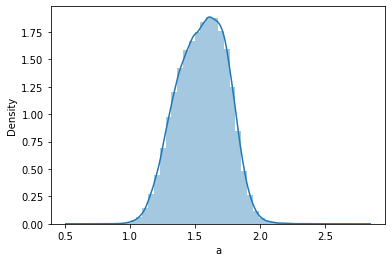

In [26]:
import seaborn as sns

sns.distplot(tracking_df['a']**(1/3), kde=True)

# **pffScoutingJoinPlayers和tracking_df做left join**

In [27]:
pffScoutingJoinPlayers = pd.merge(pffScoutingJoinPlayers, tracking_df, how='left', on=['gameId', 'playId', 'nflId'])
pffScoutingJoinPlayers['a_2'] = pffScoutingJoinPlayers['a']**(1/3)
pffScoutingJoinPlayers

,gameId,playId,nflId,pff_hit,pff_hurry,pff_sack,weight,age,ageStage,heightCm,a,a_2
0,2021090900,97,53441,0.0,1.0,0.0,245,0.0,0,190.50,7.62,1.967818
1,2021090900,137,41915,0.0,0.0,0.0,250,30.0,3,187.96,3.67,1.542489
2,2021090900,137,53461,0.0,0.0,0.0,262,0.0,0,195.58,3.75,1.553616
3,2021090900,187,41915,0.0,0.0,0.0,250,30.0,3,187.96,3.02,1.445447
4,2021090900,282,41915,0.0,0.0,0.0,250,30.0,3,187.96,5.44,1.758732
...,...,...,...,...,...,...,...,...,...,...,...,...
12967,2021110100,4113,52591,0.0,0.0,0.0,233,24.0,4,195.58,6.13,1.830151
12968,2021110100,4113,53479,0.0,0.0,0.0,250,0.0,0,187.96,4.37,1.634910
12969,2021110100,4113,53645,0.0,0.0,0.0,232,0.0,0,190.50,3.81,1.561858
12970,2021110100,4310,53479,0.0,0.0,0.0,250,0.0,0,187.96,5.86,1.802876


# **加速度做LabelEncoding**

In [28]:
a_conditions = [
    (pffScoutingJoinPlayers['a_2'] < 1), 
    (pffScoutingJoinPlayers['a_2'] >= 1) & (pffScoutingJoinPlayers['a_2'] < 1.5), 
    (pffScoutingJoinPlayers['a_2'] >= 1.5) & (pffScoutingJoinPlayers['a_2'] < 2), 
    (pffScoutingJoinPlayers['a_2'] >= 2)
]

aStage = [1, 2, 3, 4]

pffScoutingJoinPlayers['aStage'] = np.select(a_conditions, aStage)

# **取得Metric 球員身體素質指標**

## (身高 + 體重) / 2 * 壓力值 * 年齡優勢 * 最快加速度

### 壓力值
> #### 依照 pff_hit, pff_hurry, pff_sack 給分
> #### pff_hit = 1.2
> #### pff_hurry = 1.1
> #### pff_sack = 1.6

### 年齡優勢
> #### 未滿30歲給1.2分
> #### 30-34給1.175分
> #### 35-39給1.5分
> #### 40以上給1.25分
> #### 沒有值給原始分數

### 加速度
> #### 未滿1給原始分數
> #### 1-1.49給1.1分
> #### 1.49-1.9給1.2分
> #### 2以上給1.3分

In [29]:
def setMetricCol(df): 
    for index, row in df.iterrows():
        h = row['heightCm']
        w = row['weight']
        a = row['ageStage']
        a2 = row['aStage']
        
        metric = (h + w) / 2
        
        if row['pff_hit'] != 0:
            metric *= 1.2
            
        if row['pff_hurry'] != 0:
            metric *= 1.1
            
        if row['pff_sack'] != 0:
            metric *= 1.6
            
        if a == 4:
            metric *= 1.2
        elif a == 3:
            metric *= 1.175
        elif a == 2:
            metric *= 1.15
        elif a == 1:
            metric *= 1.125
        elif a == 0:
            metric *= 1
            
        if a2 == 4:
            metric *= 1.3
        elif a2 == 3:
            metric *= 1.2
        elif a2 == 2:
            metric *= 1.1
        elif a2 == 1:
            metric *= 1
            
        df.loc[index, 'metric'] = metric
        
setMetricCol(pffScoutingJoinPlayers)

pffScoutingJoinPlayers

,gameId,playId,nflId,pff_hit,pff_hurry,pff_sack,weight,age,ageStage,heightCm,a,a_2,aStage,metric
0,2021090900,97,53441,0.0,1.0,0.0,245,0.0,0,190.50,7.62,1.967818,3,287.43000
1,2021090900,137,41915,0.0,0.0,0.0,250,30.0,3,187.96,3.67,1.542489,3,308.76180
2,2021090900,137,53461,0.0,0.0,0.0,262,0.0,0,195.58,3.75,1.553616,3,274.54800
3,2021090900,187,41915,0.0,0.0,0.0,250,30.0,3,187.96,3.02,1.445447,2,283.03165
4,2021090900,282,41915,0.0,0.0,0.0,250,30.0,3,187.96,5.44,1.758732,3,308.76180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12967,2021110100,4113,52591,0.0,0.0,0.0,233,24.0,4,195.58,6.13,1.830151,3,308.57760
12968,2021110100,4113,53479,0.0,0.0,0.0,250,0.0,0,187.96,4.37,1.634910,3,262.77600
12969,2021110100,4113,53645,0.0,0.0,0.0,232,0.0,0,190.50,3.81,1.561858,3,253.50000
12970,2021110100,4310,53479,0.0,0.0,0.0,250,0.0,0,187.96,5.86,1.802876,3,262.77600


In [30]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', 100)

# pffScoutingJoinPlayers.head(30)